In [13]:
import neuralflow
import numpy as np
import matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
from neuralflow.utilities.visualization_functions import plot_spikes, plot_fitting_results
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [14]:
print(neuralflow.__file__)

/Users/xinzheng/Desktop/Engel_rotation/TestBrainFlow/neuralflow/__init__.py


## Data Generation for Periodic Boundary:

The idea to implement periodic boundary condition on domain $(0, L)$ is to simply set: 

$$f(x+ kL) = f(x) \quad k \in \mathbb{R}$$

for both boundries, which assumes that the 1D space is wrapped around, as demo-ed in the unit cell below:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2e/Limiteperiodicite.svg/1200px-Limiteperiodicite.svg.png" alt="Drawing" style="width: 300px;" />

## Generate synthetic data


### Uniform Potential
We generate the data with noise magnitude $D=0.2$, and narrow bell-shaped initial distribution centered at $x = 0.5$ for the latent states. To begin with, we use **uniform** potential, which means that the latent trajectory will be subjected to pure random walk drifting. To go from latent state $X(t)$ to spikes $Y(t)$, we treat spikes as an inhomogeneous Poisson process that depend on the time-varying intensity $f(x(t))$, a linear function of  latent trajectory $x(t)$.


Here we generate 5 trials of data, and each trial havs 5 seconds maximum duration.

After we perform data generation, we will visualize latent trajectories and spike rasters of the generated data. 

In [15]:
def plot_latent(em):
    
    
    fig, ax = plt.subplots(nrows = 2, figsize = [5, 8], 
                       gridspec_kw={'height_ratios': [1, 2]})

    # plot initial distribution
    ax[0].plot(em.x_d_, em.p0_, color = "navy", linewidth = 1.5) # pltential function

    # Hide the right and top spines
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax[0].set_yticks(ticks = [0, 6])
    ax[0].set_xticks(ticks = [-1, 0, 1])
    ax[0].set_xlim([-1,1])
    ax[0].set_ylim([0,6])

    ax[0].xaxis.set_ticks_position('bottom')
    ax[0].set_ylabel("$p_{0}(x)$", fontsize = 14)
    ax[0].set_title("Initial Distribution", fontsize = 16)

    # plot potential function ----------------------------------------
    ax[1].plot(em.x_d_, -np.log(em.peq_), color = "black", linewidth = 2) # pltential function


    # Hide the right and top spines
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax[1].set_yticks([])
    ax[1].set_xticks(ticks = [-1, 0, 1])
    ax[1].set_xlim([-1.1,1.05])
    ax[1].xaxis.set_ticks_position('bottom')
    ax[1].set_ylabel("$\Phi (x)$", fontsize = 14)
    ax[1].set_title("Potential Function", fontsize = 16)

    plt.show()
    
    fig.savefig("latent.pdf")

In [16]:
def plot_simu(spikes, time_bins, diff_traj):

    fig, ax = plt.subplots(ncols = 2, figsize = [16, 6],
                       gridspec_kw = {'width_ratios': [1,1]} )
    
    # plot trajectory ----------------------------------------------
    ax[0].set_prop_cycle(plt.cycler('color', plt.cm.viridis(np.linspace(0, 1, 5))))
    for i in range(5):
        ax[0].plot(time_bins[i]*1000, diff_traj[i], '.',  markersize = .2)

    ax[0].set_xlabel('Time (ms)',fontsize=14)
    ax[0].set_ylabel(r'Latent states, $x$',fontsize=14)
    ax[0].tick_params(axis='both', which='major', labelsize=13)
    ax[0].set_ylim([-1, 1])
    ax[0].set_yticks([-1, 0, .5, 1])
    ax[0].set_title("Latent Trajectory", fontsize = 16)

    # plot raster -------------------------------------------------
    cmap = plt.get_cmap('viridis', 5)  
    cmap_color = [cmap(n/5) for n in range(5)]
    # bc time in spikes data are intervals instead of t = tn, so use build-in func:
    plot_spikes(spikes[list(range(5))],ax[1], cmap_color)
    ax[1].set_xlabel('Time (ms)',fontsize=14)
    ax[1].set_ylabel('Trials',fontsize=14)
    ax[1].tick_params(axis='both', which='major', labelsize=13)
    ax[1].set_title("Spike Rasters", fontsize = 16)

    plt.show()
    
    fig.savefig("simulation.png", dpi = 300)

In [17]:
# single well p0 (bell curve), with flat potential:
EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 64}}}, 
               'Nv': 447,  
               'peq_model':{"model": "uniform", "params": {}},
               'D0': 0.07,
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": .5}},
               'boundary_mode':'circular', 
               'num_neuron':1,
               'firing_model':[{"model": "sinus", "params": {"bias": 15, "amp": 10}}],
               'verbose':True
               }
em_uni=neuralflow.EnergyModel(**EnergyModelParams)

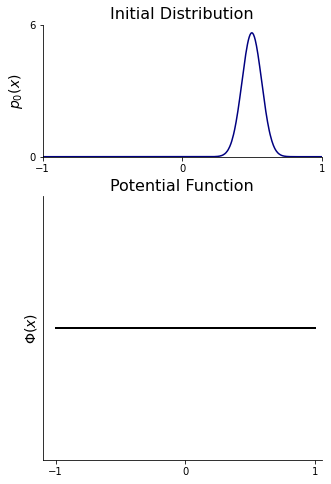

In [18]:
plot_latent(em_uni)

### Simulate Spikes

In [19]:
# (0, 5) is duration * number of trials:
data_gen_params={'deltaT':0.0001, 'time_epoch':  [(0,5)]*5, 'last_event_is_spike':False}
spikes, time_bins, diff_traj, metadata=em_uni.generate_data(**data_gen_params)

100%|██████████| 5/5 [00:02<00:00,  2.12it/s]


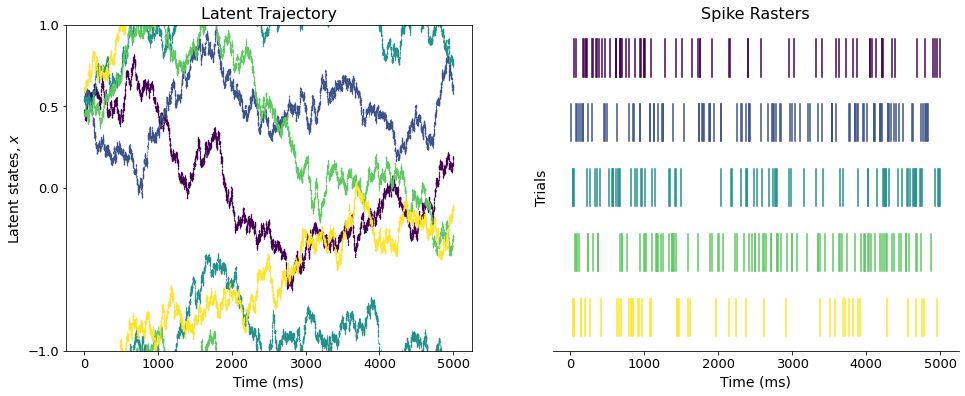

In [20]:
plot_simu(spikes, time_bins, diff_traj)

### Centering Potential

We also take a look at the case when the initial distribution and the equilibrium distribution centers at the same $x$ in the latent space, where we choose cosine square as the potential function $\Phi(x)$:

In [21]:
# single well p0 (bell curve), with flat potential:
EnergyModelParams={'pde_solve_param':{'method':{'name': 'SEM', 'gridsize': {'Np': 8, 'Ne': 64}}}, 
               'Nv': 447,  
               'peq_model':{"model": "cos_square", "params": {}},
               'D0': 0.07,
               'p0_model':{"model": "single_well", "params": {"miu": 200, "xmin": 0}},
               'boundary_mode':'circular', 
               'num_neuron':1,
               'firing_model':[{"model": "sinus", "params": {"bias": 15, "amp": 10}}],
               'verbose':True
               }
em_cosq=neuralflow.EnergyModel(**EnergyModelParams)

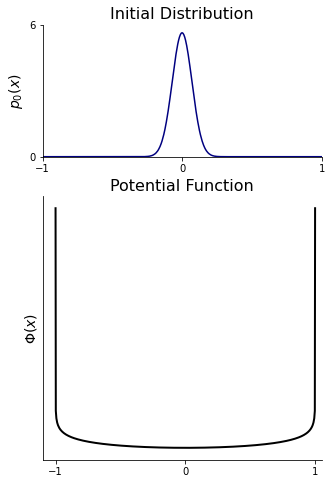

In [22]:
plot_latent(em_cosq)

### Simulate Spikes

In [23]:
# (0, 5) is duration * number of trials:
data_gen_params={'deltaT':0.0001, 'time_epoch':  [(0,5)]*5, 'last_event_is_spike':False}
spikes, time_bins, diff_traj, metadata=em_cosq.generate_data(**data_gen_params)

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


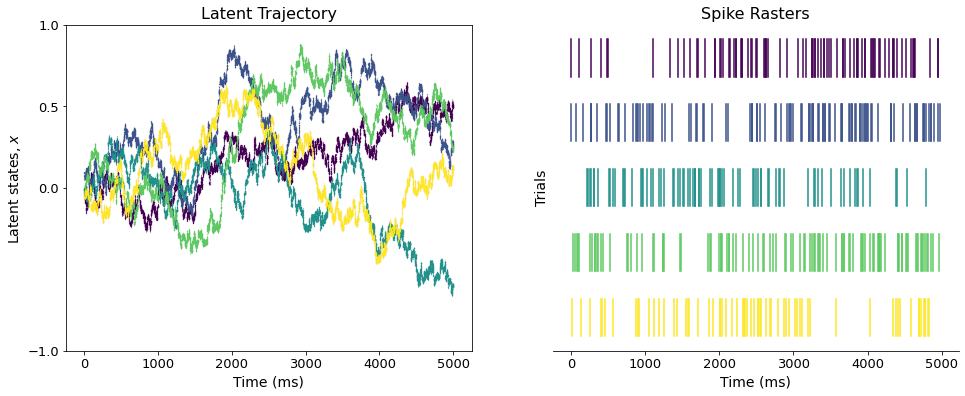

In [24]:
plot_simu(spikes, time_bins, diff_traj)